In [1]:
import numpy as np
from numpy import mean
from numpy import absolute
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
salesdata = pd.read_csv("house_sales.csv")
df = pd.DataFrame(salesdata)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# Remove rows with null values
clean_data = df.dropna()
clean_data.count()

id               17618
date             17618
price            17618
bedrooms         17618
bathrooms        17618
sqft_living      17618
sqft_lot         17618
floors           17618
waterfront       17618
view             17618
condition        17618
grade            17618
sqft_above       17618
sqft_basement    17618
yr_built         17618
yr_renovated     17618
zipcode          17618
lat              17618
long             17618
sqft_living15    17618
sqft_lot15       17618
dtype: int64

In [4]:
# Get the row count for each subset column
subset = clean_data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built', 'zipcode']]
subset.count()

price          17618
bedrooms       17618
bathrooms      17618
sqft_living    17618
sqft_lot       17618
yr_built       17618
zipcode        17618
dtype: int64

In [5]:
# For good practice, remove duplicates
subset.drop_duplicates()
subset.count()

price          17618
bedrooms       17618
bathrooms      17618
sqft_living    17618
sqft_lot       17618
yr_built       17618
zipcode        17618
dtype: int64

In [6]:
# Select independent and dependent variables
x_subset_living_lot = subset[['sqft_living', 'sqft_lot']]
y_subset_price = subset[['price']]
X_subset_living_lot = sm.add_constant(x_subset_living_lot)

In [7]:
# Create an OLS regression model before removing outliers
regression_model = sm.OLS(y_subset_price, X_subset_living_lot)
results = regression_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     8750.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:30:53   Log-Likelihood:            -2.4475e+05
No. Observations:               17618   AIC:                         4.895e+05
Df Residuals:                   17615   BIC:                         4.895e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.834e+04   4876.899     -9.913      

In [8]:
# Create a function thata removes outliers from a column
def rm_outliers_mean(column):
  col_data = subset[[column]]

  mean = col_data.mean()
  quartile1 = col_data.quantile(0.25)
  quartile3 = col_data.quantile(0.75)
  iqr = quartile3 - quartile1

  low_outliers = quartile1 - 1.5 * iqr
  high_outliers = quartile3 + 1.5 * iqr

  outliers_df = df[~((col_data < low_outliers) | (col_data > high_outliers))]
  mean_outliers_removed = outliers_df[[column]].count()
  return mean, mean_outliers_removed

In [9]:
# Remove outliers from columns and calculate the mean
clean_price = rm_outliers_mean('price')
clean_sqft_living = rm_outliers_mean('sqft_living')
clean_sqft_lot = rm_outliers_mean('sqft_lot')
print('Price:', clean_price, '\n\nSqft Living:', clean_sqft_living, '\n\nSqft Lot:',
      clean_sqft_lot)

Price: (price    541643.730787
dtype: float64, price    16669
dtype: int64) 

Sqft Living: (sqft_living    2083.482915
dtype: float64, sqft_living    17133
dtype: int64) 

Sqft Lot: (sqft_lot    15140.852026
dtype: float64, sqft_lot    15625
dtype: int64)


In [10]:
# Create a function that removes rows with outliers from a DataFrame
def rm_outliers(df):
  for col in df.columns:
    quartile1 = df[col].quantile(0.25)
    quartile3 = df[col].quantile(0.75)
    iqr = quartile3 - quartile1

    low_outliers = quartile1 - 1.5 * iqr
    high_outliers = quartile3 + 1.5 * iqr

    outlier = (df[col] < low_outliers) | (df[col] > high_outliers)
    df = df.drop(df[outlier].index)
  return df

In [11]:
# Get the count of rows for each column with outliers removed
rm_outliers_df = rm_outliers(subset)
rm_outliers_df.count()

price          14309
bedrooms       14309
bathrooms      14309
sqft_living    14309
sqft_lot       14309
yr_built       14309
zipcode        14309
dtype: int64

In [12]:
# Select independent and dependent variables
x_living_lot = rm_outliers_df[['sqft_living', 'sqft_lot']]
y_price = rm_outliers_df[['price']]
X_living_lot = sm.add_constant(x_living_lot)

In [13]:
# Create an OLS regression model with outliers removed
regression_model = sm.OLS(y_price, X_living_lot)
results = regression_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     3974.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:30:53   Log-Likelihood:            -1.9175e+05
No. Observations:               14309   AIC:                         3.835e+05
Df Residuals:                   14306   BIC:                         3.835e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.888e+05   4482.443     42.126      

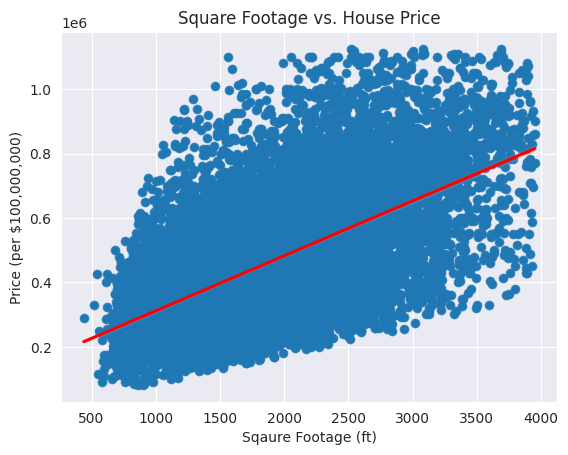

In [14]:
# Plot the regression model for square footage and house price
sns.set_style('darkgrid')
sns.scatterplot(x='sqft_living', y='price', data=rm_outliers_df)
sns.regplot(x='sqft_living', y='price', data=rm_outliers_df, line_kws={'color':'red'})
plt.title('Square Footage vs. House Price')
plt.xlabel('Sqaure Footage (ft)')
plt.ylabel('Price (per $100,000,000)')
#xaxis = np.array([0, 15000])
#yaxis = np.array([0, 1000000])
plt.show()

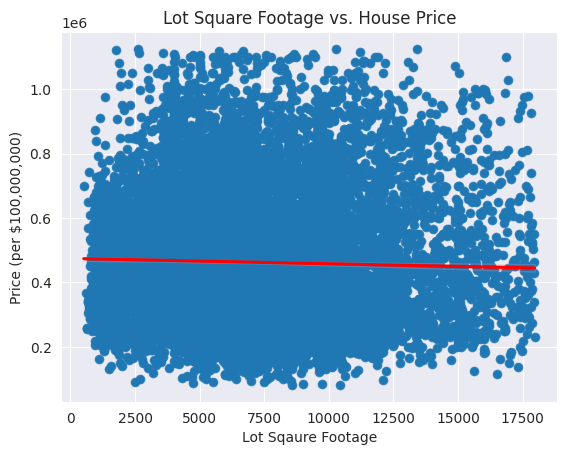

In [15]:
# Plot the regression model for lot square footage and house price
sns.set_style('darkgrid')
sns.scatterplot(x='sqft_lot', y='price', data=rm_outliers_df)
sns.regplot(x='sqft_lot', y='price', data=rm_outliers_df, line_kws={'color':'red'})
plt.title('Lot Square Footage vs. House Price')
plt.xlabel('Lot Sqaure Footage')
plt.ylabel('Price (per $100,000,000)')
plt.yscale('linear')
plt.show()

In [16]:
# Adjust the DF so I can train and test the model
#x = rm_outliers_df[['sqft_living', 'sqft_lot']]
#y = rm_outliers_df[['price']]
#X = sm.add_constant(x)

In [17]:
# initialize train and test for both variables
X_train, X_test, y_train, \
y_test = train_test_split(X_living_lot, y_price, test_size = 0.25, 
                          random_state = 222)

In [18]:
# Get the size of train and test sizes
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]

# Get the percentage of train and test sizes
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', round(train_percent * 100, 2), '\nTest Size:', 
      round(test_percent * 100, 2))

Train Size: 74.99 
Test Size: 25.01


In [19]:
# Get the OLS regression model results
price_model = sm.add_constant(X_train)

price_model_results = sm.OLS(y_train, X_train).fit()
price_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     2988.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:31:01   Log-Likelihood:            -1.4380e+05
No. Observations:               10731   AIC:                         2.876e+05
Df Residuals:                   10728   BIC:                         2.876e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.881e+05   5161.257     36.438      0.000    1.78e+05    1.98e+05
sqft_living   180.7678      2.341     77.219      0.000     176.179     185.357
sqft_lot       -9.2524      0.465    -19.886      0.000     -10.164      -8.340
==============================================================================
Omnibus:                      536.215   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              620.702
Skew:                           0.566   Prob(JB):                    1.65e-135
Kurtosis:                       3.324   Cond. No.                     2.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Get predictions
price_mod = LinearRegression()
price_mod.fit(X_train, y_train)
y_pred = price_mod.predict(X_test)
y_pred

array([[480391.26665254],
       [703134.23802066],
       [589292.62406   ],
       ...,
       [511364.80767019],
       [424726.6634164 ],
       [352791.88336214]])

In [21]:
# Output the model accuracy
accuracy = price_mod.score(X_test, y_test)
print(str(round(accuracy * 100, 2)) + '% accuracy')

35.49% accuracy


In [22]:
# Calculate the mean absolute error
mse = mean_absolute_error(y_test, y_pred)
print('$' + str(round(mse, 2)))

$128041.98


In [23]:
# Get the mean absolute error for home price
cv = KFold(n_splits=5, random_state=222, shuffle=True)
price = cross_val_score(price_mod, X_train, y_train, 
                         scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
ma_price = mean(absolute(price))
print('$' + str(round(ma_price, 2)))

$127919.03


# Lets see if we can make an accurate model with zipcodes and home prices

In [24]:
# Select independent and dependent variables
x_subest_zipcode = subset[['zipcode']]
y_subset_price = subset[['price']]
X_subset_zipcode = sm.add_constant(x_subest_zipcode)

In [25]:
# Create an OLS regression model before removing outliers
regression_model = sm.OLS(y_subset_price, X_subset_zipcode)
results = regression_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     48.52
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           3.38e-12
Time:                        00:31:05   Log-Likelihood:            -2.5080e+05
No. Observations:               17618   AIC:                         5.016e+05
Df Residuals:                   17616   BIC:                         5.016e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.597e+07   5.09e+06      7.072      0.0

In [26]:
# Select independent and dependent variables
x_zipcode = rm_outliers_df[['zipcode']]
#y_rm_price = rm_outliers_df[['price']]
X_zipcode = sm.add_constant(x_zipcode)

In [27]:
# Create an OLS regression model before removing outliers
regression_model = sm.OLS(y_price, X_zipcode)
results = regression_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.898
Date:                Fri, 14 Apr 2023   Prob (F-statistic):             0.0269
Time:                        00:31:05   Log-Likelihood:            -1.9491e+05
No. Observations:               14309   AIC:                         3.898e+05
Df Residuals:                   14307   BIC:                         3.898e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -6.25e+06   3.03e+06     -2.061      0.0

In [28]:
unique_zipcodes = rm_outliers_df['zipcode'].nunique()
unique_zipcodes

70

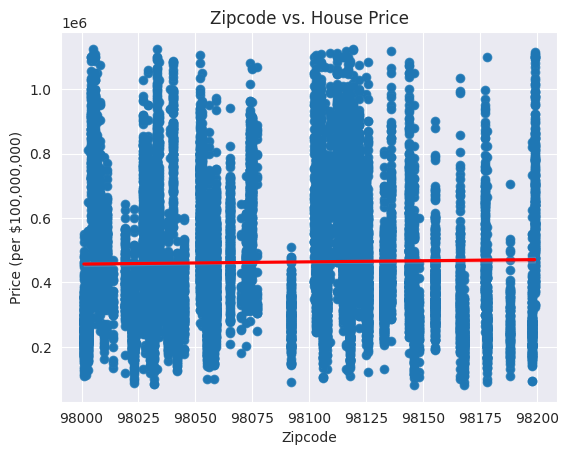

In [29]:
# Plot the regression model for zipcode and house price
sns.set_style('darkgrid')
sns.scatterplot(x='zipcode', y='price', data=rm_outliers_df)
sns.regplot(x='zipcode', y='price', data=rm_outliers_df, line_kws={'color':'red'})
plt.title('Zipcode vs. House Price')
plt.xlabel('Zipcode')
plt.ylabel('Price (per $100,000,000)')
#xaxis = np.array([0, 15000])
#yaxis = np.array([0, 1000000])
plt.show()

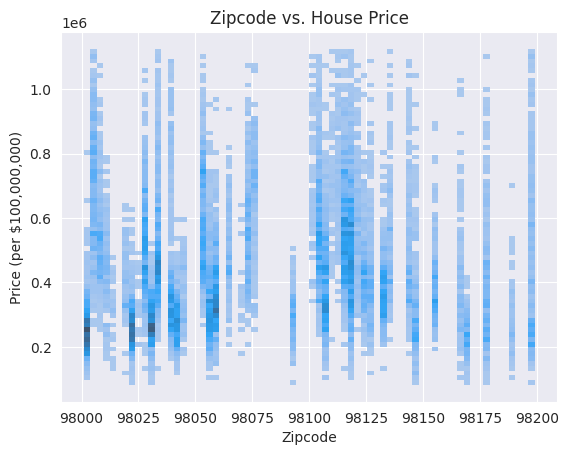

In [30]:
# Plot the regression model for zipcode and house price
sns.set_style('darkgrid')
sns.histplot(x='zipcode', y='price', data=rm_outliers_df, bins=70)
#sns.regplot(x='zipcode', y='price', data=rm_outliers_df, line_kws={'color':'red'})
plt.title('Zipcode vs. House Price')
plt.xlabel('Zipcode')
plt.ylabel('Price (per $100,000,000)')
#xaxis = np.array([0, 15000])
#yaxis = np.array([0, 1000000])
plt.show()

In [31]:
# Adjust the DF so I can train and test the model
#price_X = rm_outliers_df.drop(columns=['price'])
#price_y = rm_outliers_df[['price']]

In [32]:
# Adjust the DF so I can train and test the model
#x = rm_outliers_df[['zipcode']]
#y = rm_outliers_df[['price']]
#X = sm.add_constant(x)

In [33]:
# initialize train and test for both variables
X_train, X_test, y_train, \
y_test = train_test_split(X_zipcode, y_price, test_size = 0.25, 
                          random_state = 222)

In [34]:
# Get the size of train and test sizes
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]

# Get the percentage of train and test sizes
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', round(train_percent * 100, 2), '\nTest Size:', 
      round(test_percent * 100, 2))

Train Size: 74.99 
Test Size: 25.01


In [35]:
# Get the OLS regression model results
customers_model = sm.add_constant(X_train)

customers_model_results = sm.OLS(y_train, X_train).fit()
customers_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.974
Date:                Fri, 14 Apr 2023   Prob (F-statistic):             0.0258
Time:                        00:31:08   Log-Likelihood:            -1.4617e+05
No. Observations:               10731   AIC:                         2.924e+05
Df Residuals:                   10729   BIC:                         2.924e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.352e+06    3.5e+06     -2.098      0.036   -1.42e+07   -4.84e+05
zipcode       79.6622     35.719      2.230      0.026       9.646     149.679
==============================================================================
Omnibus:                      877.671   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.933
Skew:                           0.785   Prob(JB):                    9.57e-242
Kurtosis:                       3.123   Cond. No.                     1.79e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# Get predictions
zipcode_mod = LinearRegression()
zipcode_mod.fit(X_train, y_train)
y_pred = zipcode_mod.predict(X_test)
y_pred

array([[469309.5008719 ],
       [457360.16481812],
       [465167.06437325],
       ...,
       [464370.44196967],
       [464370.44196967],
       [455527.93328987]])

In [37]:
# Output the model accuracy
accuracy = zipcode_mod.score(X_test, y_test)
print(str(round(accuracy * 100, 2)) + '% accuracy')

-0.06% accuracy


In [38]:
# Calculate the mean absolute error
# Calculate the mean absolute error
mse = mean_absolute_error(y_test, y_pred)
print('$' + str(round(mse, 2)))

$160460.74


In [39]:
# Get the mean absolute error for home price
cv = KFold(n_splits=5, random_state=222, shuffle=True)
price = cross_val_score(price_mod, X_train, y_train, 
                         scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
ma_price = mean(absolute(price))
print('$' + str(round(ma_price, 2)))

$160801.41


# Lets use all the data from the subset DataFrame to predict home prices
*(This may result in overfitting)*

In [40]:
x_all = subset[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built', 'zipcode']]
X_all = sm.add_constant(x_all)

In [41]:
# initialize train and test for both variables
X_train, X_test, y_train, \
y_test = train_test_split(X_all, y_subset_price, test_size = 0.25, 
                          random_state = 222)

In [42]:
# Get the size of train and test sizes
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]

# Get the percentage of train and test sizes
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', round(train_percent * 100, 2), '\nTest Size:', 
      round(test_percent * 100, 2))

Train Size: 75.0 
Test Size: 25.0


In [43]:
# Get the OLS regression model results
customers_model = sm.add_constant(X_train)

customers_model_results = sm.OLS(y_train, X_train).fit()
customers_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2750.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:31:09   Log-Likelihood:            -1.8266e+05
No. Observations:               13213   AIC:                         3.653e+05
Df Residuals:                   13206   BIC:                         3.654e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.807e+06   4.28e+06     -1.589      0.112   -1.52e+07    1.59e+06
bedrooms    -7.452e+04   2952.233    -25.242      0.000   -8.03e+04   -6.87e+04
bathrooms    8.547e+04   4775.891     17.897      0.000    7.61e+04    9.48e+04
sqft_living   305.6056      3.845     79.471      0.000     298.068     313.143
sqft_lot       -0.2664      0.052     -5.142      0.000      -0.368      -0.165
yr_built    -3001.8077     89.280    -33.622      0.000   -3176.809   -2826.806
zipcode       129.4983     43.070      3.007      0.003      45.074     213.923
==============================================================================
Omnibus:                     7985.417   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           216845.091
Skew:                           2.425   Prob(JB):                         0.00
Kurtosis:                      22.244   Cond. No.                     2.01e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Get predictions
zipcode_mod = LinearRegression()
zipcode_mod.fit(X_train, y_train)
y_pred = zipcode_mod.predict(X_test)
y_pred

array([[874010.96514163],
       [557711.6704865 ],
       [552860.22092927],
       ...,
       [512165.13785583],
       [546094.49879108],
       [736728.64111417]])

In [45]:
# Output the model accuracy
accuracy = zipcode_mod.score(X_test, y_test)
print(str(round(accuracy * 100, 2)) + '% accuracy')

56.18% accuracy


# Lets use all the data with outliers removed to predict home prices
*(This may result in overfitting)*

In [46]:
x_rmo_all = rm_outliers_df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built', 'zipcode']]
X_rmo_all = sm.add_constant(x_rmo_all)

In [47]:
# initialize train and test for both variables
X_train, X_test, y_train, \
y_test = train_test_split(X_rmo_all, y_price, test_size = 0.25, 
                          random_state = 222)

In [48]:
# Get the size of train and test sizes
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]

# Get the percentage of train and test sizes
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', round(train_percent * 100, 2), '\nTest Size:', 
      round(test_percent * 100, 2))

Train Size: 74.99 
Test Size: 25.01


In [49]:
# Get the OLS regression model results
customers_model = sm.add_constant(X_train)

customers_model_results = sm.OLS(y_train, X_train).fit()
customers_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     1341.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:31:09   Log-Likelihood:            -1.4317e+05
No. Observations:               10731   AIC:                         2.864e+05
Df Residuals:                   10724   BIC:                         2.864e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.265e+06   3.01e+06     -1.418      0.156   -1.02e+07    1.63e+06
bedrooms     -3.45e+04   2390.807    -14.429      0.000   -3.92e+04   -2.98e+04
bathrooms     4.57e+04   3544.814     12.893      0.000    3.88e+04    5.27e+04
sqft_living   205.3680      3.466     59.258      0.000     198.575     212.161
sqft_lot       -8.8970      0.477    -18.647      0.000      -9.832      -7.962
yr_built    -1985.9341     62.960    -31.543      0.000   -2109.348   -1862.521
zipcode        85.0213     30.239      2.812      0.005      25.747     144.295
==============================================================================
Omnibus:                      466.328   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              555.467
Skew:                           0.488   Prob(JB):                    2.41e-121
Kurtosis:                       3.538   Cond. No.                     2.03e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# Get predictions
zipcode_mod = LinearRegression()
zipcode_mod.fit(X_train, y_train)
y_pred = zipcode_mod.predict(X_test)
y_pred

array([[486508.03055521],
       [706573.48065892],
       [576143.77277372],
       ...,
       [564862.86197091],
       [380393.71103266],
       [336877.78200308]])

In [51]:
# Output the model accuracy
accuracy = zipcode_mod.score(X_test, y_test)
print(str(round(accuracy * 100, 2)) + '% accuracy')

42.93% accuracy
